In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%cd gdrive/My\ Drive/KKB-kaggle/bengaliai-cv19/notebooks

/content/gdrive/My Drive/KKB-kaggle/bengaliai-cv19/notebooks


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
import copy
import torch

In [0]:
dataset_dir = '../dataset'
train_df = pd.read_csv(dataset_dir + '/train.csv')
test_df = pd.read_csv(dataset_dir + '/test.csv')
class_map_df = pd.read_csv(dataset_dir + '/class_map.csv')
sample_sub_df = pd.read_csv(dataset_dir + '/sample_submission.csv')

In [5]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [6]:
test_df.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [7]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [8]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [9]:
# データの形状
print(f'Size of training data: {train_df.shape}')
print(f'Size of test data: {test_df.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [10]:
# 各grapheme_root, consonant_diacritic, vowel_diacriticが何回出現しているのかを調べたい
# それぞれのgrapheme_root, consonant_diacritic, vowel_diacriticについての情報をまとめるDataFrameを作成する

root_df = class_map_df[class_map_df['component_type']=='grapheme_root']
print(f'Size: {root_df.shape}')
cons_df = class_map_df[class_map_df['component_type']=='consonant_diacritic'].reset_index(drop=True)
print(f'Size: {cons_df.shape}')
vowel_df = class_map_df[class_map_df['component_type']=='vowel_diacritic'].reset_index(drop=True)
print(f'Size: {vowel_df.shape}')

Size: (168, 3)
Size: (7, 3)
Size: (11, 3)


In [11]:
root_df.drop(columns=['component_type'], inplace=True)
cons_df.drop(columns=['component_type'], inplace=True)
vowel_df.drop(columns=['component_type'], inplace=True)
root_df['count'] = train_df.groupby(['grapheme_root']).size()
cons_df['count'] = train_df.groupby(['consonant_diacritic']).size()
vowel_df['count'] = train_df.groupby(['vowel_diacritic']).size()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
root_df

,label,component,count
0,0,ং,147
1,1,ঃ,145
2,2,অ,337
3,3,আ,318
4,4,ই,331
...,...,...,...
163,163,হ্ল,165
164,164,ৎ,164
165,165,ড়,1142
166,166,ঢ়,307


In [13]:
cons_df

,label,component,count
0,0,0,125278
1,1,ঁ,7424
2,2,র্,23465
3,3,র্য,619
4,4,্য,21270
5,5,্র,21397
6,6,্র্য,1387


In [14]:
vowel_df

,label,component,count
0,0,0,41508
1,1,া,36886
2,2,ি,25967
3,3,ী,16152
4,4,ু,18848
5,5,ূ,5297
6,6,ৃ,4336
7,7,ে,28723
8,8,ৈ,3528
9,9,ো,16032


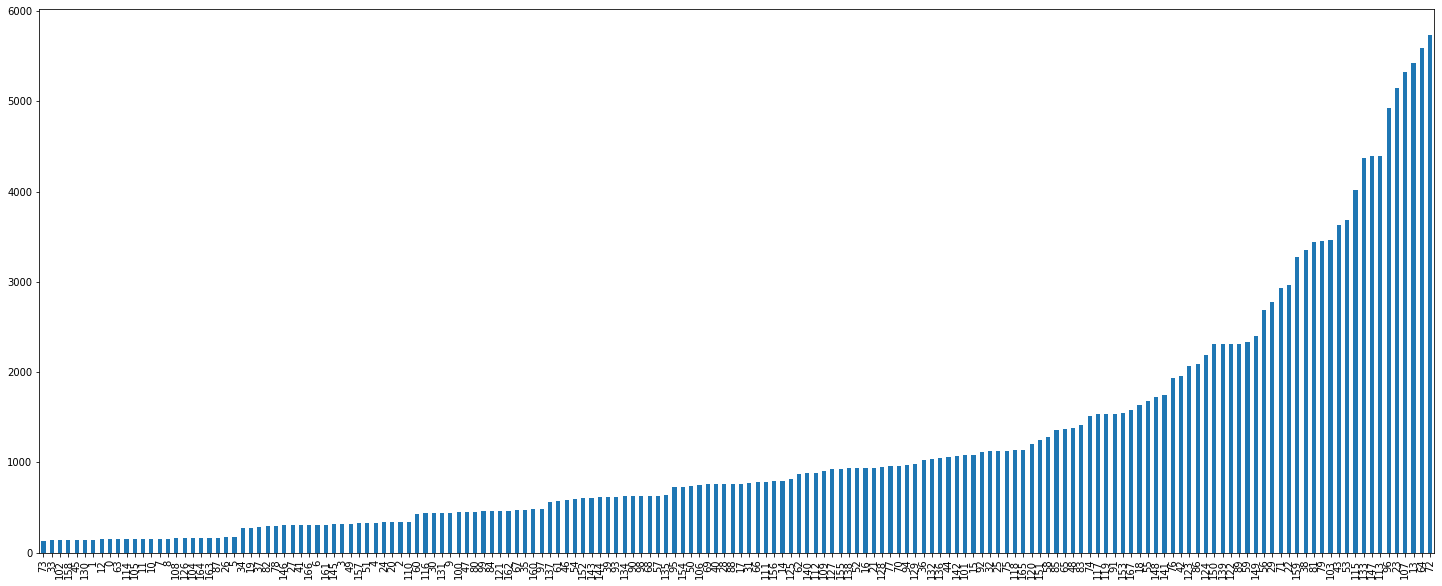

In [15]:
# 各grapheme_rootの出現数がどんな分布になっているか。昇順にsortしてグラフ表示
root_df.sort_values(by=['count'])['count'].plot(kind='bar', figsize=(25,10))

In [0]:
# 目標： parquetファイルから画像を取り込み、PyTorchのDatasetクラスとしてモデルに入れられるようにする

# parquetファイルから取り込んで、train_dfに結合する
# 全train_dataをいっぺんに扱うとメモリを圧迫するため、train_image_data_1.parquetのデータのみとりあえず扱う

train_df_with_img = pd.merge(pd.read_parquet(dataset_dir + '/train_image_data_1.parquet'), train_df, on='image_id').drop(['image_id'], axis=1)

In [17]:
# 画像は '0' から '32331' に格納された。　32332 = 137 x 236
train_df_with_img.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,246,253,251,250,249,252,246,250,250,247,250,247,245,246,250,250,243,251,250,244,247,251,248,247,250,247,245,248,250,248,249,248,249,248,244,249,248,247,248,247,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,253,74,0,2,র্দ্দ
1,250,245,241,244,249,253,253,254,254,254,254,254,254,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,254,253,253,254,254,254,253,254,253,254,255,255,255,255,255,255,255,254,254,255,255,254,254,254,254,255,254,254,253,253,253,254,255,253,253,254,28,2,0,গ্লি
2,248,248,249,249,250,251,250,250,249,250,252,251,250,251,251,247,248,250,246,243,248,249,248,247,246,244,246,247,247,247,246,249,248,240,245,249,248,251,252,251,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,86,3,5,ন্ত্রী
3,253,252,250,252,252,251,252,252,252,251,249,252,251,251,250,247,251,249,249,250,250,249,250,251,249,250,251,250,250,250,251,250,250,251,250,251,252,251,251,252,...,254,254,254,254,254,254,254,255,254,254,254,254,255,255,255,254,253,253,253,253,253,252,252,251,251,252,252,252,253,252,252,251,250,251,251,253,76,8,0,দ্বৈ
4,250,252,252,250,250,252,253,254,254,254,253,253,252,253,253,253,251,250,252,254,254,252,252,251,250,252,253,252,250,249,252,252,252,252,252,250,250,251,252,252,...,252,251,248,245,248,251,252,251,250,250,251,251,251,251,251,251,250,250,250,250,251,252,253,252,250,250,251,252,251,250,251,252,252,252,252,252,96,10,1,পৌঁ


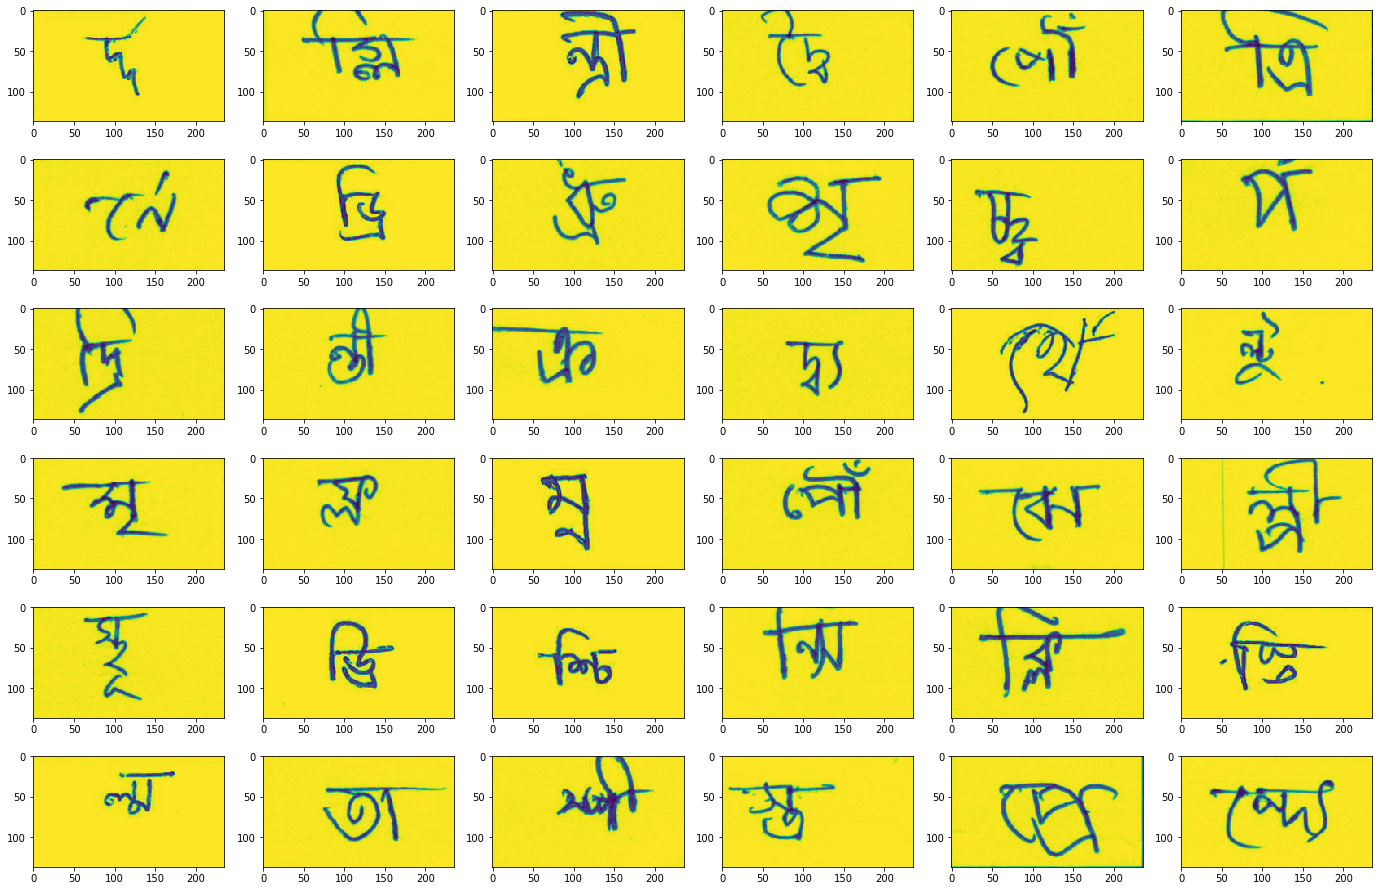

In [18]:
HEIGHT = 137
WIDTH = 236

X_train = train_df_with_img.drop(columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme'])

# 元画像を表示
# ピクセル値が255に近いほど黄色、0に近いほど濃色
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(24, 16))
count=0
for row in ax:
    for col in row:
        col.imshow(X_train.iloc[[count]].values.reshape(HEIGHT, WIDTH))
        count += 1
plt.show()

(256,)
(257,)


(0.0, 10000)

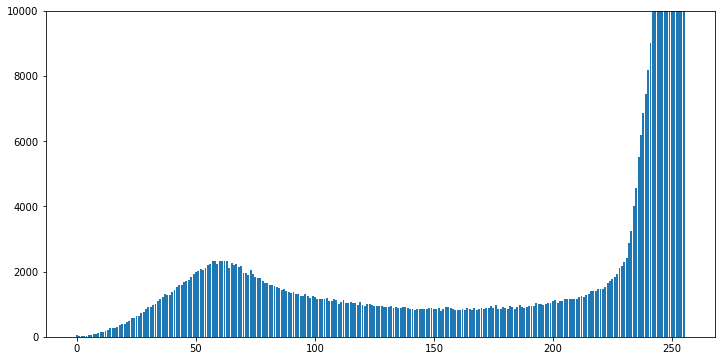

In [19]:
# ピクセルの値がどこより低ければ "文字部分" とみなすか、という閾値の適正な値を調べる
# 各ピクセル値（0〜255）の頻度をグラフにする
# グラフを見ると、60辺りで極大。文字に該当する部分は60くらいってわかる。→ 閾値は100~150くらいが適正？

h, x = np.histogram(X_train.iloc[:100].values, bins=np.arange(257))
print(h.shape)
print(x.shape)

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x[:256], h)
ax.set_ylim(top=10000)

In [0]:
# 追記：　結局上のヒストグラムの情報は使いませんでした

In [0]:
# OpenCVをつかって、文字部分を認識。文字部分を囲うようにトリミング（crop）する。
# 1つ目の画像について、途中経過を示しながら手順をおう。

# 二値化

image = X_train.iloc[[0]].values.reshape(HEIGHT, WIDTH)
_, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # サンプルコードから持ってきたけど、cv2.THRESH_OTSUを使っているので30の意味は特になさそう？

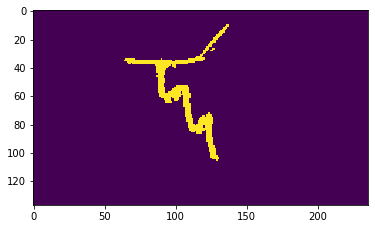

In [21]:
plt.imshow(thresh)

In [0]:
# 輪郭の抽出

contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
# [-2:]の意味はわかりません、調査中です

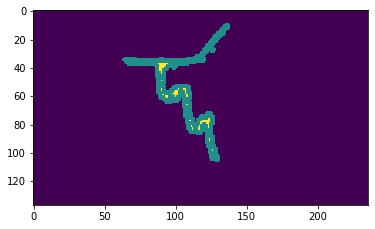

In [23]:
thresh_copy = copy.deepcopy(thresh)
plt.imshow(cv2.drawContours(thresh_copy, contours, -1, 127, 2))

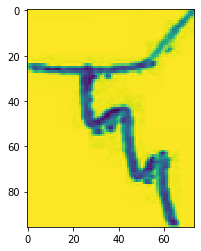

In [24]:
# 求めた輪郭を囲む bounding box (= roi) を求め、それで画像をトリミングする

# 初期値
left = 1000
right = -1
top = 1000
bottom = -1

for cnt in contours:
  x,y,w,h = cv2.boundingRect(cnt)
  left = min(x, left)
  right = max(x+w, right)
  top = min(y, top)
  bottom = max(y+h, bottom)

# roi = region of interest （注目したい領域）
roi = image[top:bottom, left:right]
plt.imshow(roi)

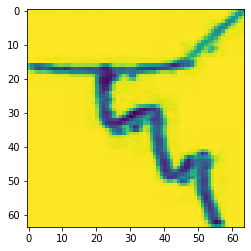

In [25]:
# 64x64に画像のサイズを変換

RESIZE_H = 64
RESIZE_W = 64

resized_roi = cv2.resize(roi, (RESIZE_H, RESIZE_W),interpolation=cv2.INTER_AREA)
plt.imshow(resized_roi)

In [26]:
resized_roi.reshape(-1).shape

(4096,)

In [27]:
# すべての画像について、上記の処理を行う
RESIZE_H = 64
RESIZE_W = 64

resized = {} # 前処理された画像が格納されるリスト

for i in tqdm(range(len(X_train))):
  image = X_train.iloc[[i]].values.reshape(HEIGHT, WIDTH)
  _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
  left = 1000
  right = -1
  top = 1000
  bottom = -1

  for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    left = min(x, left)
    right = max(x+w, right)
    top = min(y, top)
    bottom = max(y+h, bottom)

  roi = image[top:bottom, left:right]
  resized_roi = cv2.resize(roi, (RESIZE_H, RESIZE_W),interpolation=cv2.INTER_AREA)
  resized[i] = resized_roi.reshape(-1)


In [28]:
len(resized)

50210

In [29]:
X_train_resized = pd.DataFrame(resized).T / 255.0   # 値を0~1におさめる
X_train_resized = X_train_resized.values
X_train_resized

array([[0.99215686, 0.99215686, 0.99215686, ..., 0.99607843, 0.99607843,
        0.99607843],
       [0.99607843, 0.99607843, 0.99607843, ..., 1.        , 0.99607843,
        0.99607843],
       [0.94117647, 0.82745098, 0.6745098 , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.98823529, 0.98431373, 0.98431373, ..., 1.        , 1.        ,
        1.        ],
       [0.95294118, 0.95294118, 0.96078431, ..., 0.99215686, 0.99215686,
        0.99215686],
       [0.9254902 , 0.81960784, 0.64313725, ..., 0.99607843, 0.99607843,
        1.        ]])

In [0]:
# PyTorchのデータセットクラスを作る前に、ラベルの情報も整備
# 1-of-K符号化とか、One Hot Encodingとか呼ばれる方法でラベルをつくる

Y_train_root = pd.get_dummies(train_df_with_img['grapheme_root']).values
Y_train_cons = pd.get_dummies(train_df_with_img['consonant_diacritic']).values
Y_train_vowel = pd.get_dummies(train_df_with_img['vowel_diacritic']).values

Y_train = [Y_train_root, Y_train_cons, Y_train_vowel]

In [0]:
# PyTorch式のデータセットクラスを定義

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, X, Y, transform=None):
        self.transform = transform
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        out_data = self.X[idx]
        out_data = torch.tensor(out_data)

        root_label = torch.tensor(self.Y[0][idx])
        cons_label = torch.tensor(self.Y[1][idx])
        vowel_label = torch.tensor(self.Y[2][idx])
        out_label = [root_label, cons_label, vowel_label]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [32]:
dataset = MyDataset(X_train_resized, Y_train)
image, label = dataset[0]
print(image.size(), label)

torch.Size([4096]) [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.uint8), tensor([0, 0, 1, 0, 0, 0, 0], dtype=torch.uint8), tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)]
